# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into Pytorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the pytorch domain libraries for existing data loading functions and customizable loading funcitions.



# 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.8.0+cu126'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#1. Get Data

our dataset is a subset of the Food 101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750training , 250 testing)

our dataset starts with 3 classes of food and only 10% of the images (~75training, 25 testing)



In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} dir already exists")
else:
  print(f"{image_path} does not exist,creating one...")
  image_path.mkdir(parents=True, exist_ok=True)


# Download pizza,steak and sushi data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza,steak,sushi data")
  f.write(request.content)

# unzip pizza,steak, sushi data
with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip","r") as zip_ref:
  print("unzipping pizza, steak,sushi data")
  zip_ref.extractall (image_path)


data/pizza_steak_sushi does not exist,creating one...
unzipping pizza, steak,sushi data


## 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  """walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [6]:
# setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##2.1 Visualizing and image
Let's write some code to:
1. Get all of the image paths
2. pick a random image path using python's random.choice()
3. Get the image class name using 'pathlib.path.parent.stem'
4. since we're working with images, let's open the image with pythion's PIL
5. we'll then show the image and print metadata

data/pizza_steak_sushi/test/sushi/1680893.jpg
sushi
Random image path: data/pizza_steak_sushi/test/sushi/1680893.jpg
image calss: sushi
height: 512
width: 512


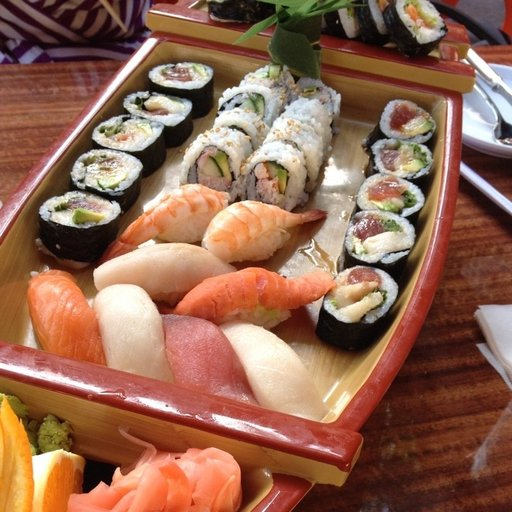

In [7]:
import random
from PIL import Image

#random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. get image class from path name (the image class is the name of the firectory whrere the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. open image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")
print(f"image calss: {image_class}")
print(f"height: {img.height}")
print(f"width: {img.width}")
img

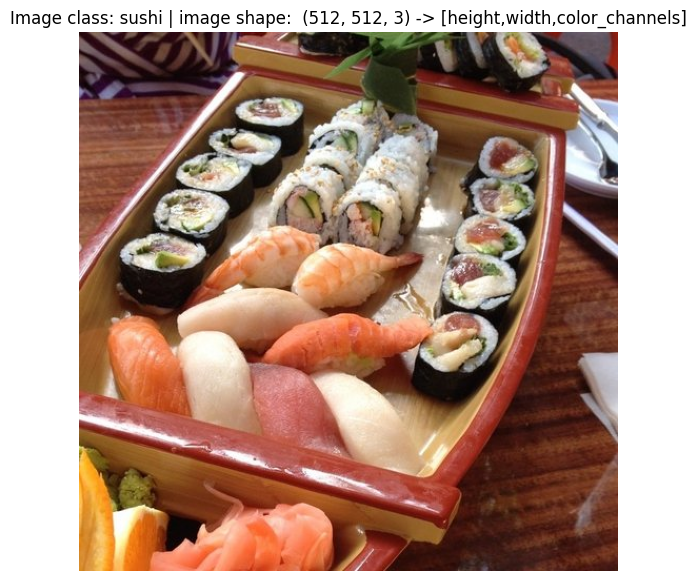

In [8]:
# Try to visualize and image with matplotlib...

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | image shape:  {img_as_array.shape} -> [height,width,color_channels]")
plt.axis(False);

array([[[ 34,   8,   9],
        [ 36,  10,  11],
        [ 40,  11,  15],
        ...,
        [136,  30,  16],
        [141,  31,  16],
        [140,  30,  15]],

       [[ 37,  11,  12],
        [ 35,   9,  10],
        [ 36,   7,  11],
        ...,
        [136,  30,  16],
        [141,  31,  18],
        [140,  30,  15]],

       [[ 45,  17,  16],
        [ 39,  10,  12],
        [ 34,   5,   9],
        ...,
        [135,  29,  15],
        [141,  31,  18],
        [140,  30,  17]],

       ...,

       [[221, 144,  40],
        [218, 141,  37],
        [216, 141,  40],
        ...,
        [ 66,  28,  19],
        [ 64,  26,  15],
        [ 60,  22,  11]],

       [[219, 142,  36],
        [217, 140,  36],
        [214, 139,  38],
        ...,
        [ 65,  27,  18],
        [ 66,  28,  17],
        [ 65,  27,  16]],

       [[218, 141,  35],
        [215, 138,  34],
        [213, 138,  36],
        ...,
        [ 67,  29,  20],
        [ 71,  33,  22],
        [ 73,  35,  24]]], dtype=uint8)
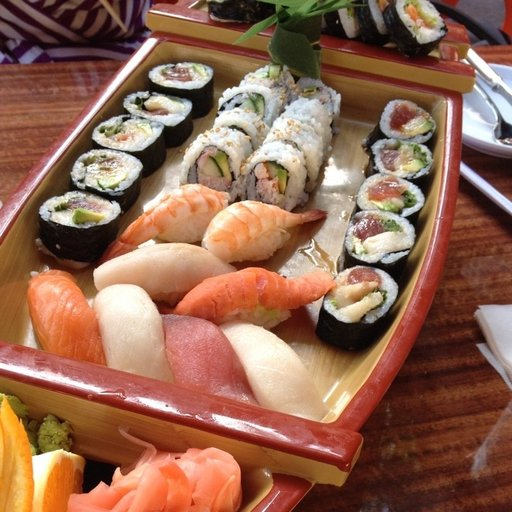

In [9]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. turn your target data into tensors (in our case, numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`
Transforms help you get your images ready to be used with a model/perform data augmentation

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image to 64* 64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

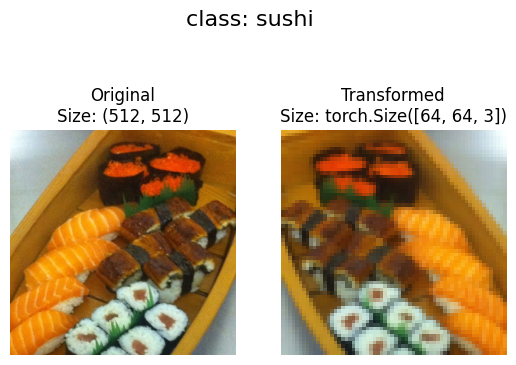

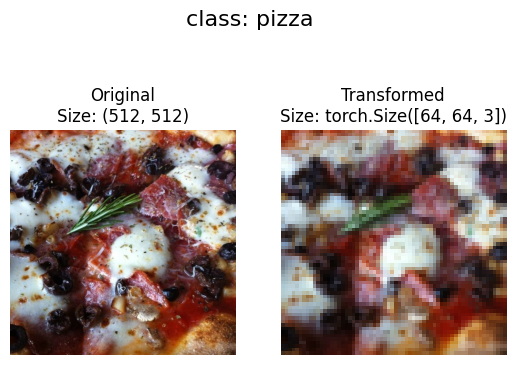

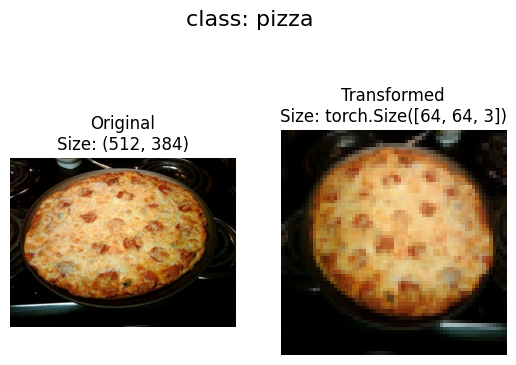

In [13]:
def plot_transformed_images(image_paths:list,transform,n=3,seed=None):
  """
  selects random images from a path of images and loads/tranforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_path  = random.sample(image_paths,k = n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # we will need to chage shape for matplotilb
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis("off")
      fig.suptitle(f"class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [14]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list

class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Index on the train_data Dataset to get a single image and label
img, label= train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape:\n {img.shape}")
print(f"Image datatype:\n {img.dtype}")
print(f"Image label: {label}")
print(f"Iabel datatype:\n {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels,height,width]
Image permute: torch.Size([64, 64, 3]) -> [height,width, color_channels]


Text(0.5, 1.0, 'pizza')

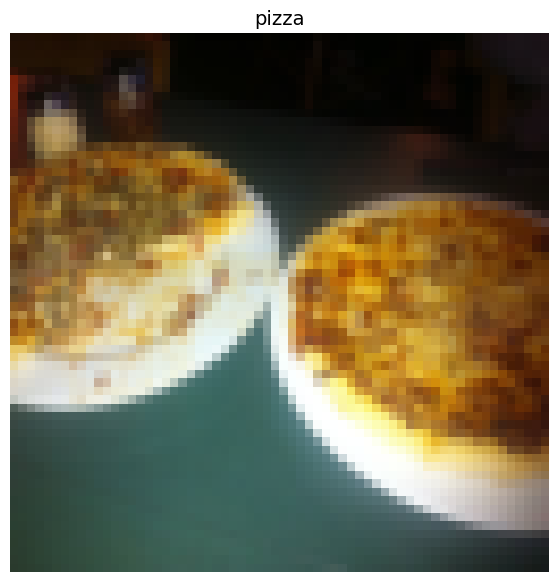

In [19]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels,height,width]")
print(f"Image permute: {img_permute.shape} -> [height,width, color_channels]")

#Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`s

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customise the `batch_size` images at a time

In [20]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)


In [21]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [22]:
len(train_data), len(test_data)

(225, 75)

In [23]:
img, label = next(iter(train_dataloader))

# Batch size will be now 1, you can change the batch size if you like
print(f"Image shape : {img.shape}-> [batch_size,color_channels,height,width]")
print(f"label shape: {label.shape}")

Image shape : torch.Size([1, 3, 64, 64])-> [batch_size,color_channels,height,width]
label shape: torch.Size([1])


## 5 option2: Loading Image data with a custom `Dataset`

1. want to be able to load images from file
2. want to be able to get calss names form the dataset
3. want to be able to get classes as dictionary from the Dataset

pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` FunctionSchema

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* Using a custom `Dataset` often results in us writing more code, which could be  prone to errors or performance issues

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes , train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

we want a funcion to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard ima ge clasification format)
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them.


In [26]:
# setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory:str) -> Tuple[list[str],Dict[str,int]]:
  """ Finds the class foler names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform
if we'd like to transform our data.

3. Create several attributes:
 *paths: -paths of our images
 *transform - the transform we'd like to  use
 *classes - a list of the target classes
 *class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6 .Overwrite the `__getitem__()` method to return a given sample when passed an index
                                              
                                              

In [29]:
# Write a custom dataset class
from torch.utils.data import Dataset

#1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #2. Initialize our custom dataset
  def __init__(self,targ_dir: str, transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4.Create a function to load images
  def load_image(self,index:int) -> Image.Image:
    "Opens an image via path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) ->int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6.Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index) -> Tuple[torch.Tensor,int]:
    "Returns one sample of data, data and label (X,y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else:
      return img,class_idx # return untransformed image and label



In [30]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [31]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [32]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7da3bf894740>,
 <__main__.ImageFolderCustom at 0x7da3bf883f50>)

In [33]:
len(train_data), len(train_data_custom)

(225, 225)

In [34]:
len(test_data), len(test_data_custom)

(75, 75)

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for equality between original ImageFolder and ImageFolderDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images
1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images  to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib(HWC)

In [37]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int =10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n >10:
    n=10
    display_shape = False
    print(f"For display, Purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k =n)

  # 5. setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexex and plot them with matplotlib
  for i,targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0],dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [color_channels, height,width] -> [height, width, color_channels]

    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

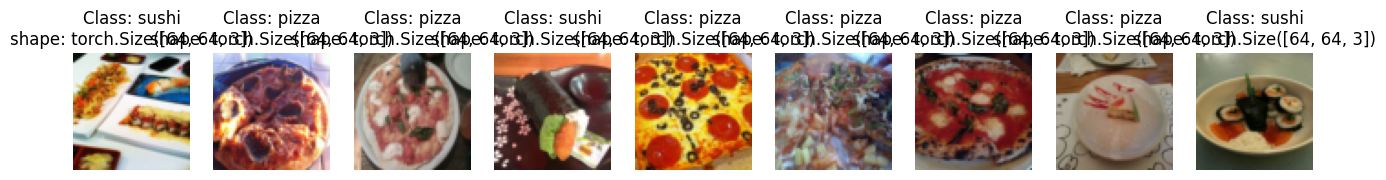

In [38]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=9,
                      classes=class_names,
                      seed=42)


 ### 5.4 Turn custom loaded images into `DataLoader`s

In [39]:
from torch.utils.data import DataLoader
BATCHSIZE=32
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size=BATCHSIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True
                                     )
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                     batch_size=BATCHSIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=False
                                     )

In [40]:
# Get image and label from custom dataloader
img_custom,label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6 . Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...



In [41]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()

])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()

])

In [42]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg')]

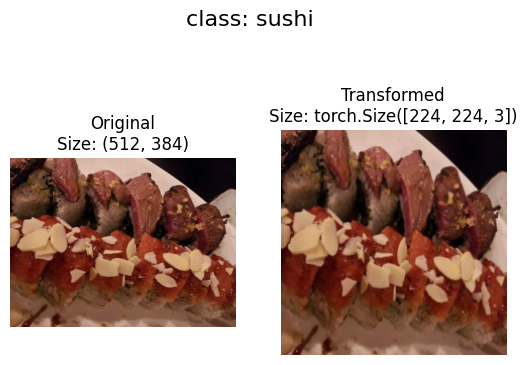

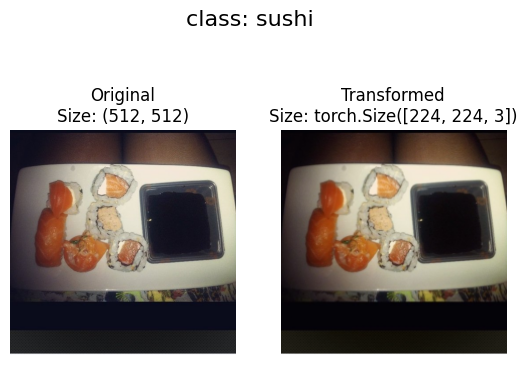

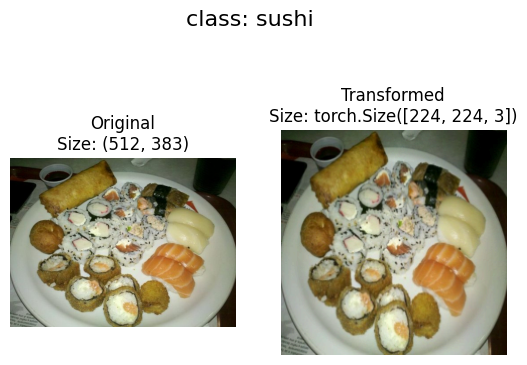

In [43]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0 : TinyVGG without data augmentation

Let's replicate TinyVGG architecture trom the CNN Explainer website: https://poloclub.github.io/cnn-explainer/


### 7.1 Creating transforms and loading data for Model 0

In [44]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [45]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batchsize and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset= train_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset= test_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [46]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self,input_shape:int,
              hidden_units: int,
              output_shape: int) ->None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=1690,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x))) #  benefits from operator fusion

In [47]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                   hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a singel image (to test the model)


In [48]:
# Get a singel image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [49]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [50]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

  from torchinfo import summary
  summary(model_0,input_size=[1,3,64,64])

In [51]:
from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops functions

* `train_step()` - takes in a model in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [52]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc =0,0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to the target device
    X,y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred,y)
    train_loss+=loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
    train_acc +=(y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [53]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y  = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y)).sum().item()/len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` functions to combine `train_step()` and `test_step()`

In [54]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int =5,
          device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(model= model,
                                      dataloader = train_dataloader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      device=device
                                      )
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | train loss: {train_loss:.4f} | train acc: {train_acc:.4f} | test loss : {test_loss:.4f} | test_acc : {test_acc:.4f}  " )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### 7.7 Train and evaluate model 0


In [55]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.1063 | train acc: 0.3047 | test loss : 1.0979 | test_acc : 0.3409  
Epoch: 1 | train loss: 1.0835 | train acc: 0.4453 | test loss : 1.0778 | test_acc : 0.4223  
Epoch: 2 | train loss: 1.1063 | train acc: 0.2812 | test loss : 1.0818 | test_acc : 0.3826  
Epoch: 3 | train loss: 1.0755 | train acc: 0.4766 | test loss : 1.0779 | test_acc : 0.5047  
Epoch: 4 | train loss: 1.0664 | train acc: 0.4023 | test loss : 1.0519 | test_acc : 0.5038  
Epoch: 5 | train loss: 0.9963 | train acc: 0.5820 | test loss : 1.0492 | test_acc : 0.3002  
Epoch: 6 | train loss: 0.8925 | train acc: 0.5625 | test loss : 1.0808 | test_acc : 0.3513  
Epoch: 7 | train loss: 0.9491 | train acc: 0.4531 | test loss : 1.0850 | test_acc : 0.3722  
Epoch: 8 | train loss: 0.9138 | train acc: 0.5078 | test loss : 1.0236 | test_acc : 0.4754  
Epoch: 9 | train loss: 0.8158 | train acc: 0.6211 | test loss : 0.9831 | test_acc : 0.4536  
Total training time: 17.679 seconds


### 7.8 Plot the loss curve of Model 0

A **loss curve** is a way of tracking your model's progress over time.


In [56]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [57]:
def plot_loss_curves(results:Dict[str, List[float]]):
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

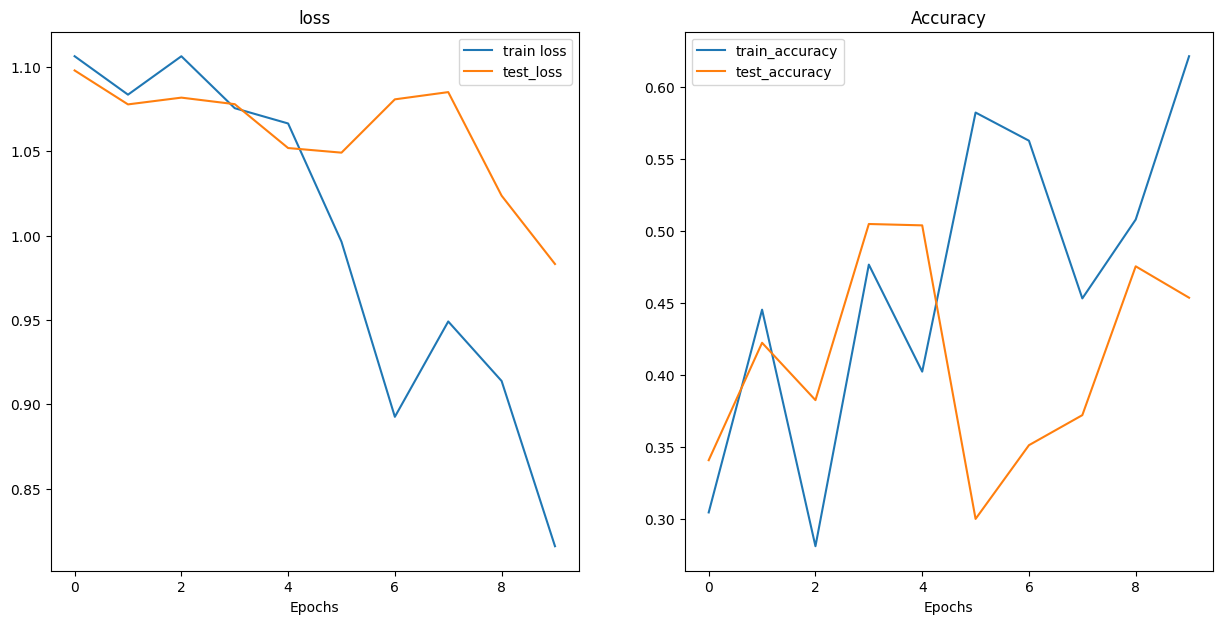

In [58]:
plot_loss_curves(model_0_results)

## 8. what should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.


## 9. Model 1: TinnyVGG with  Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation


In [59]:
from torchvision import transforms
train_transform_trival = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`s and `DataLoader`s with data augmentation

In [60]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trival)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_simple)

In [61]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [62]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

In [70]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS= 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model= model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()
print(f"total training time for model_1: {end_time-start_time:.3f}sec")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.0820 | train acc: 0.4570 | test loss : 1.0934 | test_acc : 0.2917  
Epoch: 1 | train loss: 1.0672 | train acc: 0.4453 | test loss : 1.1043 | test_acc : 0.2708  
Epoch: 2 | train loss: 1.0134 | train acc: 0.4453 | test loss : 1.1224 | test_acc : 0.2708  
Epoch: 3 | train loss: 1.0496 | train acc: 0.3789 | test loss : 1.1238 | test_acc : 0.3021  
Epoch: 4 | train loss: 1.0184 | train acc: 0.5156 | test loss : 1.1138 | test_acc : 0.3125  
Epoch: 5 | train loss: 1.0273 | train acc: 0.5195 | test loss : 1.1310 | test_acc : 0.3021  
Epoch: 6 | train loss: 0.9469 | train acc: 0.5508 | test loss : 1.0383 | test_acc : 0.2292  
Epoch: 7 | train loss: 1.0334 | train acc: 0.4297 | test loss : 1.0130 | test_acc : 0.3314  
Epoch: 8 | train loss: 1.0211 | train acc: 0.4336 | test loss : 1.0615 | test_acc : 0.4044  
Epoch: 9 | train loss: 0.9496 | train acc: 0.5703 | test loss : 0.9397 | test_acc : 0.4839  
total training time for model_1: 12.286sec


In [71]:
model_1_results

{'train_loss': [1.0820223242044449,
  1.0672156512737274,
  1.0134263634681702,
  1.0496496930718422,
  1.0184319391846657,
  1.027344524860382,
  0.9468705281615257,
  1.033398151397705,
  1.0210760608315468,
  0.9495648741722107],
 'train_acc': [0.45703125,
  0.4453125,
  0.4453125,
  0.37890625,
  0.515625,
  0.51953125,
  0.55078125,
  0.4296875,
  0.43359375,
  0.5703125],
 'test_loss': [1.093437949816386,
  1.1042942802111309,
  1.1223971446355183,
  1.1237894892692566,
  1.1137590010960896,
  1.131011684735616,
  1.038346767425537,
  1.013047715028127,
  1.0614585677782695,
  0.9397160609563192],
 'test_acc': [0.2916666666666667,
  0.2708333333333333,
  0.2708333333333333,
  0.3020833333333333,
  0.3125,
  0.3020833333333333,
  0.22916666666666666,
  0.331439393939394,
  0.4043560606060606,
  0.48390151515151514]}

### 9.4 Plot the loss curve

A loss curve helps you evaluate your models performance overtime.


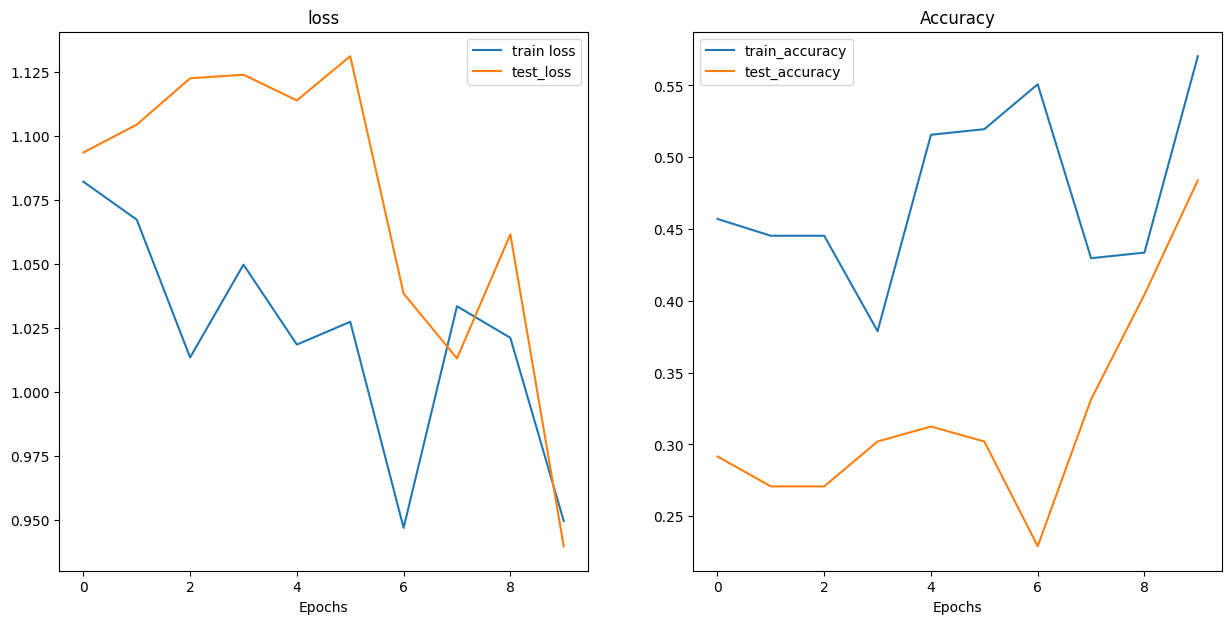

In [72]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to campare them to each other.

There's a few ways to do this

1. Hard cording
2. Pytorch + tensorboard - https://tutorials.pytorch.kr/recipes/recipes/tensorboard_with_pytorch.html
3. weights and Biases - https://wandb.ai/site/ko/experiment-tracking/
4. MLFlow - https://mlflow.org/


In [73]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.097895  0.340909
1    1.083534   0.445312   1.077762  0.422348
2    1.106304   0.281250   1.081772  0.382576
3    1.075520   0.476562   1.077896  0.504735
4    1.066448   0.402344   1.051886  0.503788
5    0.996336   0.582031   1.049150  0.300189
6    0.892544   0.562500   1.080753  0.351326
7    0.949067   0.453125   1.085043  0.372159
8    0.913783   0.507812   1.023639  0.475379
9    0.815831   0.621094   0.983143  0.453598

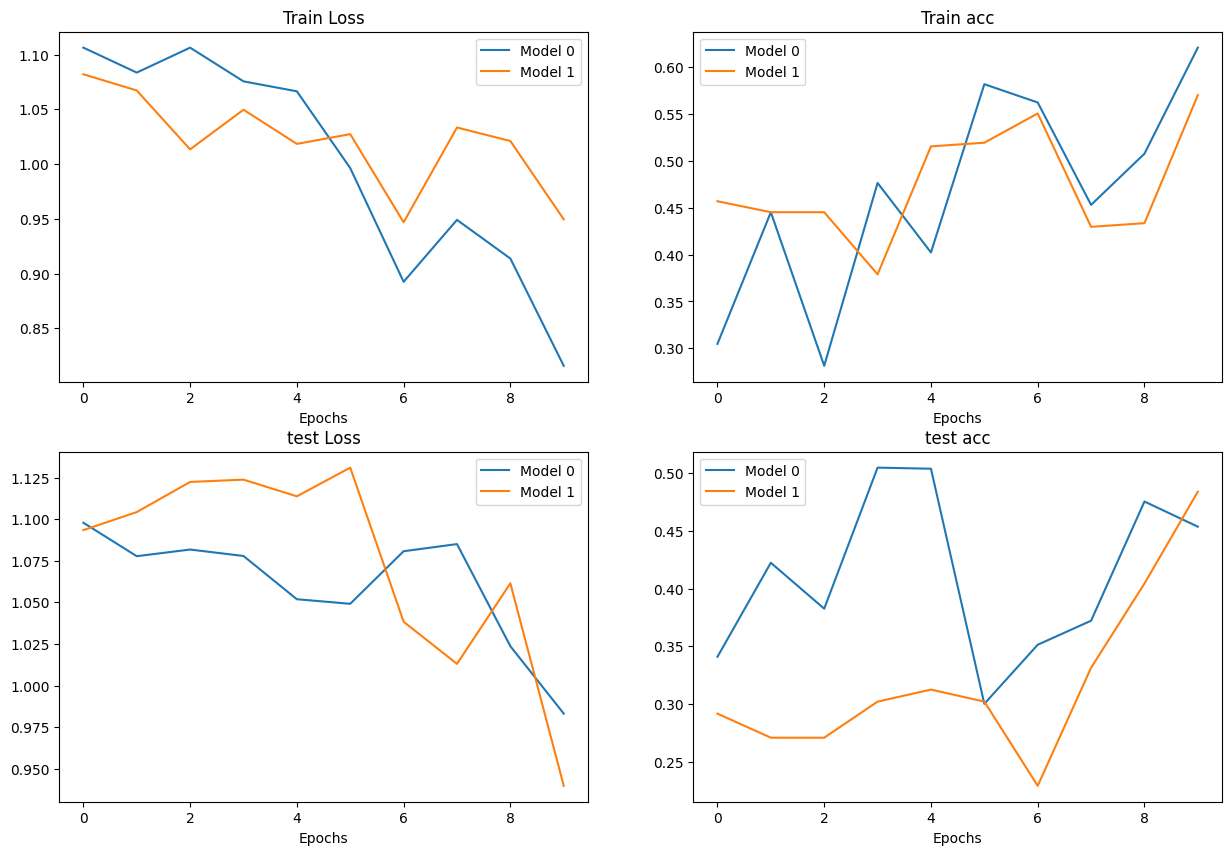

In [75]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="Model 0")
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["train_acc"],label="Model 0")
plt.plot(epochs,model_1_df["train_acc"],label="Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend();


# Plot test loss
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["test_loss"],label="Model 0")
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.title("test Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="Model 0")
plt.plot(epochs,model_1_df["test_acc"],label="Model 1")
plt.title("test acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Although we've trained a model on custom data, how do you make a prediction on a sample/image that's not in

In [97]:
#Download custom image
import requests

#setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exits")

In [102]:
### 11.1 Loading in a custom image with Pytorch

import torchvision
custom_image_path = "/content/data/pizza_steak_sushi/test/pizza/1152100.jpg"
# read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

custom_image_uint8.shape

torch.Size([3, 384, 512])

### 11.2 Making a prediction on a custom image with trained pytorch model

In [106]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.

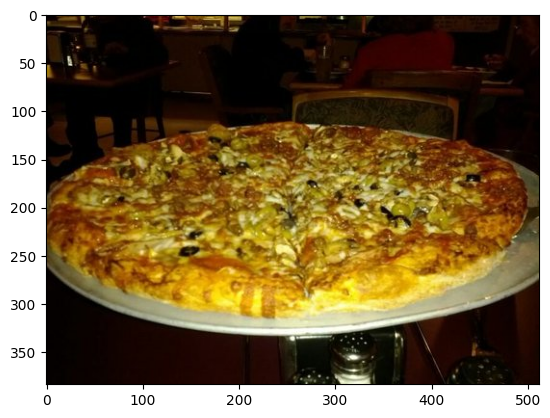

In [107]:
plt.imshow(custom_image.permute(1,2,0))

In [103]:
# Try to make a prediction on an image in uint8 format

model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [113]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([transforms.Resize(size=(64,64))])

custom_image_transformed = custom_image_transform(custom_image)

print(f"original shape: {custom_image.shape}")
print(f"transformed shape: {custom_image_transformed.shape}")

original shape: torch.Size([3, 384, 512])
transformed shape: torch.Size([3, 64, 64])


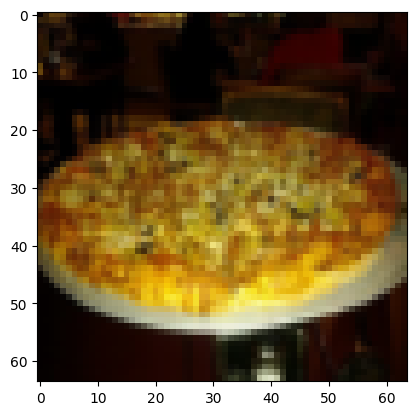

In [115]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [117]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [118]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[-0.0519, -1.1816,  0.5484]], device='cuda:0')

Note: to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained in (3,64,64) with a batch size (1,3,64,64)
* Make sure the image was on the same device as our model

In [119]:
# convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3179, 0.1027, 0.5794]], device='cuda:0')

In [121]:
custom_image_pred_labels = torch.argmax(custom_image_pred_probs,dim=1)
custom_image_pred_labels

tensor([2], device='cuda:0')

In [122]:
class_names[custom_image_pred_labels]

'sushi'

### 11.3 putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot image + prediction

In [129]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image = target_image / 255.

  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title = f"pred: {class_names[target_image_pred_labels.cpu()]} | probs: {target_image_pred_probs.max().cpu():.3f} "
  else:
    title = f"pred: {target_image_pred_labels} | prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

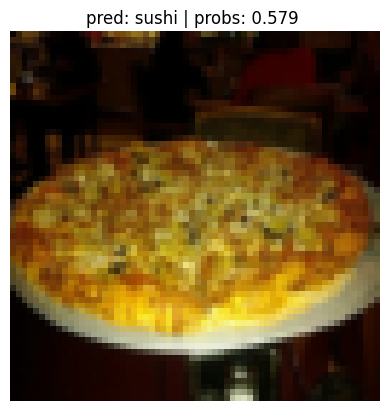

In [130]:
# Pred on our custom image
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device = device)